[View in Colaboratory](https://colab.research.google.com/github/prasad4fun/kaggle/blob/master/Planet_amazon.ipynb)

# 1 Kaggle data download

In [0]:
!pip install -q kaggle

In [0]:
!mkdir -p ~/.kaggle

In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
!kaggle datasets list

In [0]:
!kaggle competitions download -c planet-understanding-the-amazon-from-space -p /content

In [0]:
!unzip \*.zip

In [0]:
!apt-get install p7zip-full
!p7zip -d train-jpg.tar.7z
!tar -xvf train-jpg.tar

In [15]:
!p7zip -d test-jpg.tar.7z
!tar -xvf test-jpg.tar


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 632362315 bytes (604 MiB)

Extracting archive: test-jpg.tar.7z
--
Path = test-jpg.tar.7z
Type = 7z
Physical Size = 632362315
Headers Size = 98
Method = LZMA2:24
Solid = -
Blocks = 1

  0%      0% - test-jpg.tar                     1% - test-jpg.tar                     2% - test-jpg.tar                     3% - test-jpg.tar                     4% - test-jpg.tar                     5% - test-jpg.tar                     6% - test-jpg.tar                   

In [12]:
!pip install torch

    100% |████████████████████████████████| 519.5MB 32kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x59790000 @  0x7f993e8ed1c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8


In [0]:
!pip install fastai==0.7.0

# 2 Code

In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [0]:
from fastai.conv_learner import *
from fastai.plots import *

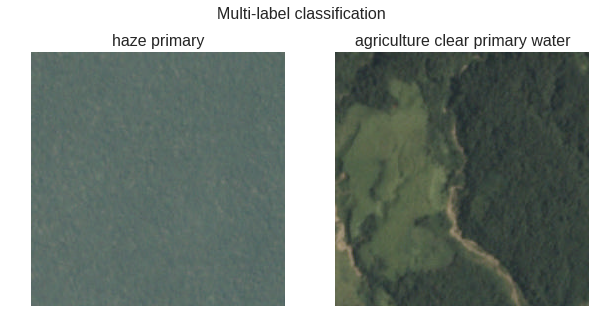

In [7]:
list_paths = ["train-jpg/train_0.jpg", "train-jpg/train_1.jpg"]
titles=["haze primary", "agriculture clear primary water"]
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

In [0]:
from fastai.imports import *
from fastai.transforms import *
from fastai.dataset import *
from sklearn.metrics import fbeta_score
import warnings

def f2(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return max([fbeta_score(targs, (preds>th), 2, average='samples')
                    for th in np.arange(start,end,step)])

In [0]:
metrics=[f2]
f_model = resnet34

In [0]:
label_csv = 'train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [0]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv('./', 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [0]:
data = get_data(256)

In [0]:
x,y = next(iter(data.val_dl))

In [21]:
list(zip(data.classes, y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

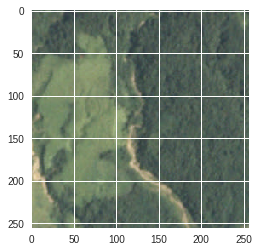

In [22]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4);

In [0]:
sz=64

In [0]:
data = get_data(sz)

In [25]:
data = data.resize(int(sz*1.3), '/tmp')

In [0]:
TMP_PATH = "/tmp/tmp"
MODEL_PATH = "/tmp/model/"

In [27]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics, tmp_name=TMP_PATH, models_name=MODEL_PATH)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:03<00:00, 26174718.01it/s]


epoch      trn_loss   val_loss   f2         
    0      0.215908   0.274681   0.82123   



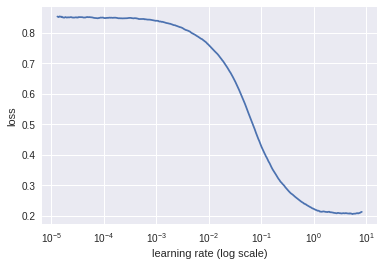

In [28]:
lrf=learn.lr_find()
learn.sched.plot()

In [29]:
lr = 0.2
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2         
    0      0.150486   0.135249   0.880732  
    1      0.141347   0.129542   0.885675  
    2      0.139131   0.127129   0.889495  
    3      0.140328   0.126821   0.890812  
    4      0.138086   0.125736   0.888263  
    5      0.131931   0.123498   0.89319   
    6      0.135198   0.123142   0.893999  



[array([0.12314]), 0.8939986002368346]

In [30]:
lrs = np.array([lr/9,lr/3,lr])
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2         
    0      0.121351   0.111119   0.904961  
    1      0.115594   0.105915   0.908604  
    2      0.108573   0.101274   0.914219  
    3      0.112409   0.102804   0.913003  
    4      0.104276   0.100498   0.912426  
    5      0.102063   0.098859   0.916999  
    6      0.101925   0.09772    0.91713   



[array([0.09772]), 0.9171297981324124]

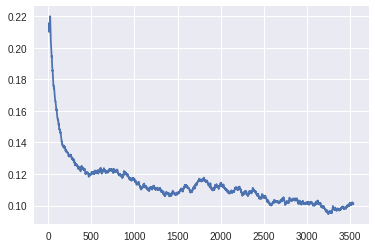

In [31]:
learn.save(f'{sz}')
learn.sched.plot_loss()

In [38]:
sz=128
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2         
    0      0.098536   0.096446   0.917886  
    1      0.098407   0.09577    0.917517  
    2      0.096829   0.095334   0.918097  
    3      0.096878   0.094996   0.918498  
    4      0.094373   0.094305   0.918871  
    5      0.09495    0.094156   0.918426  
    6      0.093882   0.093364   0.919891  



[array([0.09336]), 0.9198906429868103]

In [39]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

epoch      trn_loss   val_loss   f2         
    0      0.095081   0.08863    0.926252  
    1      0.095914   0.088873   0.92634   
    2      0.087016   0.086413   0.928453  
    3      0.095013   0.090817   0.922036  
    4      0.087373   0.088953   0.923514  
    5      0.085289   0.08543    0.928471  
    6      0.083187   0.084944   0.927992  



In [40]:
sz=256
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2         
    0      0.091319   0.088893   0.925633  
    1      0.088662   0.088421   0.925109  
    2      0.090903   0.088113   0.926137  
    3      0.087192   0.088338   0.926291  
    4      0.088687   0.08762    0.926257  
    5      0.087839   0.087004   0.92682   
    6      0.085794   0.087203   0.926603  



[array([0.0872]), 0.926602745345767]

In [0]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

In [35]:
learn.get_model_path(f'{sz}')

'/tmp/model/64.h5'

In [0]:
! cp /tmp/model/* .